In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from scipy.io import loadmat
import os
import random
from scipy.misc import imread
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
def lrelu(x, alpha):
    return tf.maximum(x, alpha*x)

def conv(x, filter_size, num_filters, stride, name, padding='SAME', groups=1, trainable=True):
    input_channels = int(x.get_shape()[-1])

    # Create lambda function for the convolution
    convolve = lambda x, W: tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)

    with tf.variable_scope(name):
        # Create tf variables for the weights and biases of the conv layer
        regularizer = tf.contrib.layers.l2_regularizer(1e-5)
        weights = tf.get_variable('W',
                                  shape=[filter_size, filter_size, input_channels // groups, num_filters],
                                  initializer=tf.contrib.layers.xavier_initializer(), regularizer = regularizer,
                                  trainable=trainable)
        biases = tf.get_variable('b', shape=[num_filters], trainable=trainable, initializer=tf.zeros_initializer())

        if groups == 1:
            conv = convolve(x, weights)

        else:
            # Split input and weights and convolve them separately
            input_groups = tf.split(x, groups, axis=3)
            weight_groups = tf.split(weights, groups, axis=3)
            output_groups = [convolve(i, k) for i, k in zip(input_groups, weight_groups)]

            # Concat the convolved output together again
            conv = tf.concat(output_groups, axis=3)

        return tf.nn.relu(conv + biases)

def deconv_layer(x, filter_size, num_filters, stride, name, padding='SAME', relu=True):
    activation = None
    if relu:
        activation = tf.nn.relu
    regularizer = tf.contrib.layers.l2_regularizer(1e-5)
    return tf.layers.conv2d_transpose(x, num_filters, filter_size, stride, padding=padding, kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=regularizer, activation=activation, name=name)
    
def fc(x, num_out, name, relu=True, trainable=True):
    regularizer = tf.contrib.layers.l2_regularizer(1e-5)
    num_in = int(x.get_shape()[-1])
    with tf.variable_scope(name):
        weights = tf.get_variable('W', shape=[num_in, num_out], regularizer=regularizer, initializer=tf.contrib.layers.xavier_initializer(), trainable=trainable)
        biases = tf.get_variable('b', [num_out], initializer=tf.zeros_initializer(), trainable=trainable)
        x = tf.matmul(x, weights) + biases
        if relu:
            x = tf.nn.relu(x) 
    return x

def lrn(x, radius, alpha, beta, name, bias=1.0):
    return tf.nn.local_response_normalization(x, depth_radius=radius, alpha=alpha, beta=beta, bias=bias, name=name)

def max_pool(x, filter_size, stride, name=None, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, filter_size, filter_size, 1], strides=[1, stride, stride, 1], padding=padding, name=name)

def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

def vgg(input, keep_prob=0.5, relu=False, process_input=True):
    if process_input:
        #VGG_MEAN = [103.939, 116.779, 123.68]
        VGG_MEAN = 103.939
        """
        # Convert RGB to BGR and subtract mean
        red, green, blue = tf.split(input, 3, axis=3)
        input = tf.concat([
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ], axis=3)
        """
        input = input - VGG_MEAN

    pool_ = lambda x: max_pool(x, 2, 2)
    conv_ = lambda x, output_depth, name: conv(x, 3, output_depth, 1, name=name)
    
    conv_1_1 = conv_(tf.concat([input,input,input], axis = -1), 64, 'conv1_1')
    conv_1_2 = conv_(conv_1_1, 64, 'conv1_2')
    print(conv_1_2.shape)
    pool_1 = pool_(conv_1_2)

    conv_2_1 = conv_(pool_1, 128, 'conv2_1')
    conv_2_2 = conv_(conv_2_1, 128, 'conv2_2')
    print(conv_2_2.shape)
    pool_2 = pool_(conv_2_2)

    conv_3_1 = conv_(pool_2, 256, 'conv3_1')
    conv_3_2 = conv_(conv_3_1, 256, 'conv3_2')
    conv_3_3 = conv_(conv_3_2, 256, 'conv3_3')
    print(conv_3_3.shape)
    pool_3 = pool_(conv_3_3)

    conv_4_1 = conv_(pool_3, 512, 'conv4_1')
    conv_4_2 = conv_(conv_4_1, 512, 'conv4_2')
    conv_4_3 = conv_(conv_4_2, 512, 'conv4_3')
    print(conv_4_3.shape)
    pool_4 = pool_(conv_4_3)

    conv_5_1 = conv_(pool_4, 512, 'conv5_1')
    conv_5_2 = conv_(conv_5_1, 512, 'conv5_2')
    conv_5_3 = conv_(conv_5_2, 512, 'conv5_3')
    print(conv_5_3.shape)
    pool_5 = pool_(conv_5_3)
    flattened = tf.contrib.layers.flatten(pool_5)

    fc_6 = dropout(fc(flattened, 4096, 'fc6'), keep_prob)
    fc_7 = fc(fc_6, 4096, 'fc7', relu=relu)
    return conv_1_2, conv_2_2, conv_3_3, conv_4_3, conv_5_3, fc_7

def vgg_simple(input, keep_prob = 0.5, relu=False):
    pool_ = lambda x: max_pool(x, 2, 2)
    conv_ = lambda x, output_depth, name: conv(x, 3, output_depth, 1, name=name)
    
    conv_1_1 = conv_(input, 16, 'conv1_1')
    pool_1 = pool_(conv_1_1)

    conv_2_1 = conv_(pool_1, 32, 'conv2_1')
    pool_2 = pool_(conv_2_1)

    conv_3_1 = conv_(pool_2, 64, 'conv3_1')
    pool_3 = pool_(conv_3_1)

    conv_4_1 = conv_(pool_3, 64, 'conv4_1')
    pool_4 = pool_(conv_4_1)

    conv_5_1 = conv_(pool_4, 64, 'conv5_1')
    pool_5 = pool_(conv_5_1)
    
    flattened = tf.contrib.layers.flatten(pool_5)
    fc_6 = dropout(fc(flattened, 4096, 'fc6'), keep_prob)
    fc_7 = fc(fc_6, 4096, 'fc7', relu=relu)
    return fc_7

In [3]:
class Generator(object):
    def __init__(self):
        self.train_variables = []
        self.has_defined_layers = False
        self.has_defined_C1 = False
        self.has_defined_vgg_ = False
    
    def init_network(self, discriminator):
        self.p_t_n = tf.placeholder(tf.float32, [None, 224, 224,L])
        self.p_t = tf.placeholder(tf.float32, [None, 224, 224,L])
        self.x_t = tf.placeholder(tf.float32, [None, 224, 224, 1])
        self.x_t_n = tf.placeholder(tf.float32, [None, 224, 224, 1])
        self.x_t_n_predicted = self.get_output_tensor(self.p_t_n, self.p_t, self.x_t)
        self.x_t_n_test = self.get_output_tensor(self.p_t_n, self.p_t, self.x_t, 1.0)
        mean_l2 = lambda x, y: tf.reduce_mean(tf.squared_difference(x, y))
        self.l2_loss = tf.check_numerics(mean_l2(self.x_t_n, self.x_t_n_predicted), "l2")
        self.feat_loss = tf.check_numerics(mean_l2(self.C1(self.x_t), self.C1(self.x_t_n_predicted)), "feat")
#         feat_loss = mean_l2(self.C1(self.x_t), self.C1(self.x_t_n_predicted))+mean_l2(self.vgg(self.x_t), self.vgg(self.x_t_n_predicted))
        self.adv_loss = tf.check_numerics(-tf.reduce_mean(tf.log(discriminator.get_output_tensor(self.x_t_n_predicted, self.p_t_n))), "adv")
        self.loss = self.l2_loss + 0.1*self.feat_loss + 0.1*self.adv_loss
        self.opt = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(self.loss, var_list=self.train_variables)
#         self.check_op = tf.add_check_numerics_ops()
        
    def get_output_tensor(self, p_t_n, p_t, x_t, keep_prob = 0.5):
        with tf.variable_scope('generator', reuse=self.has_defined_layers):
            p_t_n_latent = self.f_pose(p_t_n, keep_prob)
            conv_1, conv_2, conv_3, conv_4, conv_5, fc_7 = self.f_img(x_t, keep_prob)
#             latent = p_t_n_latent - self.f_pose(p_t, force_reuse=True) + self.f_img(x_t)
            latent = tf.concat((p_t_n_latent, self.f_pose(p_t, keep_prob, force_reuse=True), fc_7), axis = 1)
            output = self.f_dec(latent, conv_5, conv_4, conv_3, conv_2, conv_1)
        if not self.has_defined_layers:
            self.train_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
        self.has_defined_layers = True
        return output
        
    def f_pose(self, input, keep_prob, force_reuse=False):
        '''
        Applies f_pose function to the input tensor to get an output. Should be similar to VGG architecture
        '''
        with tf.variable_scope('f_pose', reuse=(self.has_defined_layers or force_reuse)):
            return vgg_simple(input, keep_prob)
        
    def f_img(self, input, keep_prob):
        '''
        Applies f_img function to the input tensor to get an output. Should be exactly VGG architecture
        '''
        with tf.variable_scope('f_img', reuse=self.has_defined_layers):
            return vgg(input, keep_prob, process_input=True)
        
    def f_dec(self, input, conv_5, conv_4, conv_3, conv_2, conv_1):
        '''
        Applies f_dec function to the input tensor to get an output.
        '''
        with tf.variable_scope('f_dec', reuse=self.has_defined_layers):
            reshaped = tf.reshape(input, shape=[tf.shape(input)[0], 1, 1, 4096*3])
            deconv_6_1 = deconv_layer(reshaped, 7, 128, 1, 'deconv6_1', padding='VALID')
            
            deconv_5_3 = tf.concat([deconv_layer(deconv_6_1, 3, 128, 2, 'deconv5_3'), conv_5], axis = -1)
            deconv_5_2 = deconv_layer(deconv_5_3, 3, 128, 1, 'deconv5_2')
            deconv_5_1 = deconv_layer(deconv_5_2, 3, 128, 2, 'deconv5_1')
            print("deconv: ", deconv_5_3.shape)
            deconv_4_3 = deconv_layer(deconv_5_1, 3, 128, 1, 'deconv4_3')
            deconv_4_2 = deconv_layer(deconv_4_3, 3, 128, 1, 'deconv4_2')
            deconv_4_1 = deconv_layer(deconv_4_2, 3, 64, 2, 'deconv4_1')
            print("deconv: ", deconv_4_3.shape)
            deconv_3_3 = deconv_layer(deconv_4_1, 3, 64, 1, 'deconv3_3')
            deconv_3_2 = deconv_layer(deconv_3_3, 3, 64, 1, 'deconv3_2')
            deconv_3_1 = deconv_layer(deconv_3_2, 3, 32, 2, 'deconv3_1')
            print("deconv: ", deconv_3_3.shape)
            deconv_2_2 = deconv_layer(deconv_3_1, 3, 32, 1, 'deconv2_2')
            deconv_2_1 = deconv_layer(deconv_2_2, 3, 16, 2, 'deconv2_1')
            print("deconv: ", deconv_2_2.shape)
            deconv_1_2 = deconv_layer(deconv_2_1, 3, 16, 1, 'deconv1_2')
            deconv_1_1 = deconv_layer(deconv_1_2, 3, 1, 1, 'deconv1_1')
            print("deconv: ", deconv_1_2.shape)
        return deconv_1_1
        
    def C1(self, input):
        input = tf.image.resize_images(input, [227, 227])
        with tf.variable_scope('C1', reuse=self.has_defined_C1):
            conv1 = conv(tf.concat([input,input,input], axis=-1), 11, 96, 4, padding='VALID', name='conv1', trainable=False)
            pool1 = max_pool(conv1, 3, 2, padding='VALID', name='pool1')
            norm1 = lrn(pool1, 2, 2e-5, 0.75, name='norm1')

            conv2 = conv(norm1, 5, 256, 1, groups=2, name='conv2', trainable=False)
            pool2 = max_pool(conv2, 3, 2, padding='VALID', name='pool2')
            norm2 = lrn(pool2, 2, 2e-5, 0.75, name='norm2')

            conv3 = conv(norm2, 3, 384, 1, name='conv3', trainable=False)
            conv4 = conv(conv3, 3, 384, 1, groups=2, name='conv4', trainable=False)
            conv5 = conv(conv4, 3, 256, 1, groups=2, name='conv5', trainable=False)
        self.has_defined_C1 = True
        return conv5
    
#     def vgg(self, input):
#         with tf.variable_scope('f_vgg', reuse=self.has_defined_vgg_):
#             self.has_defined_vgg_ = True
#             return vgg(input, process_input=True)


    def init_weights(self, sess, alexnet_file, vgg_file):
        weights_dict = np.load(alexnet_file, encoding='bytes').item()
        with tf.variable_scope('C1', reuse=True):
            for layer in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']:
                with tf.variable_scope(layer):
                    W_value, b_value = weights_dict[layer]
                    W = tf.get_variable('W', trainable=False)
                    b = tf.get_variable('b', trainable=False)
                    sess.run(W.assign(W_value))
                    sess.run(b.assign(b_value))
        weights_dict = np.load(vgg_file, encoding='bytes').item()
        weights_dict = { key.decode('ascii') : value for key, value in weights_dict.items() }
        with tf.variable_scope('generator/f_img', reuse=True):
            for layer in ['conv1_1', 'conv1_2',
                          'conv2_1', 'conv2_2',
                          'conv3_1', 'conv3_2', 'conv3_3',
                          'conv4_1', 'conv4_2', 'conv4_3',
                          'conv5_1', 'conv5_2', 'conv5_3',
                          'fc6', 'fc7']:
                with tf.variable_scope(layer):
                    W_value, b_value = weights_dict[layer]
                    W = tf.get_variable('W')
                    b = tf.get_variable('b')
                    sess.run(W.assign(W_value))
                    sess.run(b.assign(b_value))
    
#         with tf.variable_scope('f_vgg', reuse=True):
#             for layer in [ 'conv1_2',
#                           'conv2_1', 'conv2_2',
#                           'conv3_1', 'conv3_2', 'conv3_3',
#                           'conv4_1', 'conv4_2', 'conv4_3',
#                           'conv5_1', 'conv5_2', 'conv5_3',
#                           'fc6', 'fc7']:
#                 with tf.variable_scope(layer):
#                     W_value, b_value = weights_dict[layer]
#                     W = tf.get_variable('W')
#                     b = tf.get_variable('b')
#                     sess.run(W.assign(W_value))
#                     sess.run(b.assign(b_value))    
    
    def fit_batch(self, sess, p_t, p_t_n, x_t, x_t_n):
        _, loss = sess.run((self.opt, self.loss), feed_dict={ self.p_t : p_t, self.p_t_n : p_t_n, self.x_t : x_t, self.x_t_n : x_t_n })
        return loss
    def test_batch(self, sess, p_t, p_t_n, x_t, x_t_n):
        output = sess.run((self.x_t_n_test), feed_dict={ self.p_t : p_t, self.p_t_n : p_t_n, self.x_t : x_t, self.x_t_n : x_t_n  })
        return output
    #def test_gen(self, sess, p_t, p_t_n, x_t):
        

class Discriminator(object):
    def __init__(self):
        self.train_variables = []
        self.has_defined_layers = False
    
    def init_network(self, discriminator):
        self.p_t = tf.placeholder(tf.float32, [None, 224, 224,L])
        self.p_t_n = tf.placeholder(tf.float32, [None, 224, 224,L])
        self.x_t = tf.placeholder(tf.float32, [None, 224, 224, 1])
        self.x_t_n = tf.placeholder(tf.float32, shape=[None, 224, 224, 1])
        x_t_n_real = self.x_t_n
        x_t_n_pred = generator.get_output_tensor(self.p_t_n, self.p_t, self.x_t, 1.0)

        real_prob = self.get_output_tensor(x_t_n_real, self.p_t_n)
        fake_prob = self.get_output_tensor(x_t_n_pred, self.p_t_n)
        real_mismatch_prob = self.get_output_tensor(self.x_t, self.p_t_n)
        
        self.loss = -tf.reduce_mean(tf.log(real_prob) + 0.5 * tf.log(1.001 - fake_prob) + 0.5 * tf.log(1.001 - real_mismatch_prob))
        self.opt = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(self.loss, var_list=self.train_variables)
#         self.check_op = tf.add_check_numerics_ops()
        
    def get_output_tensor(self, x, p):
        with tf.variable_scope('discriminator', reuse=self.has_defined_layers):
            with tf.variable_scope('f_img'):
                conv_1, conv_2, conv_3, conv_4, conv_5, vgg_x = vgg(x, relu = True)
            with tf.variable_scope('f_pose'):
                vgg_p = vgg_simple(p, relu = True)
            concat = tf.concat([vgg_x, vgg_p], axis=1)
            fc8 = fc(concat, 4096, name='fc8')
            output = tf.nn.sigmoid(fc(fc8, 1, name='fc9', relu=False))
        if not self.has_defined_layers:
            self.train_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        self.has_defined_layers = True
        return output
    
    def init_weights(self, sess, alexnet_file, vgg_file):
        weights_dict = np.load(vgg_file, encoding='bytes').item()
        weights_dict = { key.decode('ascii') : value for key, value in weights_dict.items() }
        with tf.variable_scope('discriminator/f_img', reuse=True):
            for layer in ['conv1_1', 'conv1_2',
                          'conv2_1', 'conv2_2',
                          'conv3_1', 'conv3_2', 'conv3_3',
                          'conv4_1', 'conv4_2', 'conv4_3',
                          'conv5_1', 'conv5_2', 'conv5_3',
                          'fc6', 'fc7']:
                with tf.variable_scope(layer):
                    W_value, b_value = weights_dict[layer]
                    W = tf.get_variable('W')
                    b = tf.get_variable('b')
                    sess.run(W.assign(W_value))
                    sess.run(b.assign(b_value))
    
    def fit_batch(self, sess, p_t, p_t_n, x_t, x_t_n):
        _, loss = sess.run((self.opt, self.loss), feed_dict={ self.p_t : p_t, self.p_t_n : p_t_n, self.x_t : x_t, self.x_t_n : x_t_n })
        return loss

In [4]:
# tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='')

In [5]:
def restore(generator, discriminator, checkpoint):
    var_list = generator.train_variables + discriminator.train_variables
    
#     saver = tf.train.Saver(var_list={var.name.split(':')[0].replace(, 'alexnet') : var for var in var_list})
    saver.restore(sess, checkpoint)

In [6]:
L = 1

In [7]:
tf.reset_default_graph()
sess = tf.Session()

generator = Generator()
discriminator = Discriminator()

generator.init_network(discriminator)
discriminator.init_network(generator)

sess.run(tf.global_variables_initializer())

generator.init_weights(sess, 'models/alexnet.npy', 'models/vgg16.npy')
discriminator.init_weights(sess, 'models/alexnet.npy', 'models/vgg16.npy')

(?, 224, 224, 64)
(?, 112, 112, 128)
(?, 56, 56, 256)
(?, 28, 28, 512)
(?, 14, 14, 512)
('deconv: ', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(640)]))
('deconv: ', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(128)]))
('deconv: ', TensorShape([Dimension(None), Dimension(56), Dimension(56), Dimension(64)]))
('deconv: ', TensorShape([Dimension(None), Dimension(112), Dimension(112), Dimension(32)]))
('deconv: ', TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(16)]))
(?, 224, 224, 64)
(?, 112, 112, 128)
(?, 56, 56, 256)
(?, 28, 28, 512)
(?, 14, 14, 512)
('deconv: ', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(640)]))
('deconv: ', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(128)]))
('deconv: ', TensorShape([Dimension(None), Dimension(56), Dimension(56), Dimension(64)]))
('deconv: ', TensorShape([Dimension(None), Dimension(112), Dimension(112), Dimension(32)]))
('de

In [8]:
# Create dictionary of squat videos. 
# Key = video number, Value = list of frames (numpy array images) of video

# mod 0-8 for training, mod 9 for test
def process_videos(mod):
    videos = {}
    videos_test = {}
    i = 0
    for video in os.listdir('squats/'):
        if i % 9 != mod:
            videos[video] = []
            for frame in os.listdir('squats/' + str(video) + '/'):
                filename = 'squats/' + str(video) + '/' + str(frame)
                videos[video].append(imread(filename, flatten=True).reshape((224,224,1)).astype('uint8'))
        else:
            videos_test[video] = []
            for frame in os.listdir('squats/' + str(video) + '/'):
                filename = 'squats/' + str(video) + '/' + str(frame)
                videos_test[video].append(imread(filename, flatten=True).reshape((224,224,1)).astype('uint8'))
        i = i + 1

    # Create dictionary of heatmat labels for squat videos. 
    # For L = 13
    # Key = video number, Value = list of stack of joints (numpy array images (224x224x13))
    if L == 13:
        labels = {}
        labels_test = {}
        for video in os.listdir('squats_labels_multiple/'):
            if video in videos:
                labels[video] = []
                for frame in os.listdir('squats_labels_multiple/' + str(video) + '/'):
                    frame_folder = 'squats_labels_multiple/' + str(video) + '/' + str(frame) + '/'
                    temp_image_stack = np.zeros((224,224,13)).astype('uint8')
                    for i in range(13):
                        temp_image_stack[:,:,i] = imread(frame_folder + str(i)+ '.jpg').astype('uint8')
                    labels[video].append(temp_image_stack)
            elif video in videos_test:
                labels_test[video] = []
                for frame in os.listdir('squats_labels_multiple/' + str(video) + '/'):
                    frame_folder = 'squats_labels_multiple/' + str(video) + '/' + str(frame) + '/'
                    temp_image_stack = np.zeros((224,224,13)).astype('uint8')
                    for i in range(13):
                        temp_image_stack[:,:,i] = imread(frame_folder + str(i)+ '.jpg').astype('uint8')
                    labels_test[video].append(temp_image_stack)

    # For L = 1 
    # Key = video number, Value = list of heatmaps for each frame (numpy array images (224x224x1))            
    elif L == 1:
        labels = {}
        labels_test = {}
        for video in os.listdir('squats_labels/'):
            if video in videos:
                labels[video] = []
                for frame in os.listdir('squats_labels/' + str(video) + '/'):
                    filename = 'squats_labels/' + str(video) + '/' + str(frame)
                    labels[video].append(imread(filename).reshape((224,224,1)))
            elif video in videos_test:
                labels_test[video] = []
                for frame in os.listdir('squats_labels/' + str(video) + '/'):
                    filename = 'squats_labels/' + str(video) + '/' + str(frame)
                    labels_test[video].append(imread(filename).reshape((224,224,1)))
    return videos, videos_test, labels, labels_test

In [9]:
# f1,f2,h1,h2 = create_minibatch(5)
# print(sess.run((generator.adv_loss, generator.l2_loss, generator.feat_loss), feed_dict={ generator.p_t : h1, generator.p_t_n : h2, generator.x_t : f1, generator.x_t_n :f2 }))# print(gen_loss)
# # for key in labels.keys():
# #     for frame in range(len(labels[key])):
#         if len(np.unique(labels[key][frame][:,:,0])) == 1:
#             print(np.unique(labels[key][frame][:,:,0]))
# for key in videos.keys():
#     for frame in range(len(videos[key])):
#         if len(np.unique(videos[key][frame][:,:,0])) == 1:
#             print(np.unique(videos[key][frame][:,:,0]))

In [10]:
def create_minibatch(batch_size):
    frames1 = []
    heatmaps1 = []
    frames2 = []
    heatmaps2 = []
    for i in range(batch_size):
        rand_video = videos.keys()[random.randint(0,len(videos.keys())-1)]
        
        rand_int = random.randint(0,len(videos[rand_video])-1)
        frames1.append(videos[rand_video][rand_int])
        heatmaps1.append(labels[rand_video][rand_int])

        rand_int = random.randint(0,len(videos[rand_video])-1)
        frames2.append(videos[rand_video][rand_int])
        heatmaps2.append(labels[rand_video][rand_int])
    return frames1, frames2, heatmaps1, heatmaps2

def create_minibatch_test(batch_size):
    frames1 = []
    heatmaps1 = []
    frames2 = []
    heatmaps2 = []
    for i in range(batch_size):
        rand_video = videos_test.keys()[random.randint(0,len(videos_test.keys())-1)]
        
        rand_int = random.randint(0,len(videos_test[rand_video])-1)
        frames1.append(videos_test[rand_video][rand_int])
        heatmaps1.append(labels_test[rand_video][rand_int])

        rand_int = random.randint(0,len(videos_test[rand_video])-1)
        frames2.append(videos_test[rand_video][rand_int])
        heatmaps2.append(labels_test[rand_video][rand_int])
    return frames1, frames2, heatmaps1, heatmaps2


In [11]:
videos, videos_test, labels, labels_test = process_videos(1)

In [12]:
# saver = tf.train.Saver()
# saver.restore(sess, '/media/jeff/WD HDD/CS280/models/test')
# saver = tf.train.Saver()
# saver.restore(sess, '/media/jeff/WD HDD/CS280/models/gray_nodropout_10_1_1-49')
# saver.restore(sess, '/media/jeffzhang/WD HDD/model/multi-labels-100-50-5/multi-labels-test2-227')

In [16]:
epochs = 400
n_samples = 1000
batch_size = 10
display_step = 1
save_model = 50

# videos, labels = {},{}
mean_gen_losses = []
mean_disc_losses = []
mod = 0
for epoch in range(epochs):
    total_iter = n_samples // batch_size
    total_gen_loss = 0
    total_disc_loss = 0
    for i in range(total_iter):
        f1,f2,h1,h2 = create_minibatch(batch_size)
        gen_loss = generator.fit_batch(sess,h1,h2,f1,f2)
        disc_loss = discriminator.fit_batch(sess,h1,h2,f1,f2)
#         disc_loss = discriminator.fit_batch(sess,h1,h2,f1,f2)
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
    mean_gen_loss = total_gen_loss / total_iter
    mean_disc_loss = total_disc_loss / total_iter
    mean_gen_losses.append(mean_gen_loss)
    mean_disc_losses.append(mean_disc_loss)
    if (epoch + 1) % display_step == 0:
        print('epoch %s: gen_loss=%.4f, disc_loss=%.4f' % (epoch + 1, mean_gen_loss, mean_disc_loss))
    if (epoch + 1) % save_model == 0:
        saver = tf.train.Saver()
        saver.save(sess, '/media/jeff/WD HDD/CS280/models/gray_skip_first_layer_disc_fixes',global_step=epoch)

epoch 1: gen_loss=1674.9729, disc_loss=1.0805
epoch 2: gen_loss=1629.5063, disc_loss=1.0457
epoch 3: gen_loss=1484.9143, disc_loss=1.0266
epoch 4: gen_loss=1424.9892, disc_loss=1.0157
epoch 5: gen_loss=1367.6726, disc_loss=0.9936
epoch 6: gen_loss=1297.5480, disc_loss=1.0135
epoch 7: gen_loss=1329.2085, disc_loss=1.0101
epoch 8: gen_loss=1302.9600, disc_loss=0.9916
epoch 9: gen_loss=1231.7628, disc_loss=0.9777
epoch 10: gen_loss=1269.3069, disc_loss=0.9817
epoch 11: gen_loss=1187.1351, disc_loss=0.9872
epoch 12: gen_loss=1182.7943, disc_loss=0.9911
epoch 13: gen_loss=1180.9575, disc_loss=0.9804
epoch 14: gen_loss=1150.0135, disc_loss=0.9739
epoch 15: gen_loss=1146.3601, disc_loss=0.9765
epoch 16: gen_loss=1110.8502, disc_loss=0.9706
epoch 17: gen_loss=1106.4930, disc_loss=0.9652
epoch 18: gen_loss=1159.1320, disc_loss=0.9799
epoch 19: gen_loss=1152.4972, disc_loss=0.9746
epoch 20: gen_loss=1072.0155, disc_loss=0.9729
epoch 21: gen_loss=1077.4616, disc_loss=0.9659
epoch 22: gen_loss=106

KeyboardInterrupt: 

In [14]:
epochs = 300
n_samples = 1000
batch_size = 5
display_step = 1
save_model = 50

# videos, labels = {},{}
mean_gen_losses = []
mean_disc_losses = []
mod = 0
for epoch in range(150,epochs):
    total_iter = n_samples // batch_size
    total_gen_loss = 0
    total_disc_loss = 0
    for i in range(total_iter):
        f1,f2,h1,h2 = create_minibatch(batch_size)
        gen_loss = generator.fit_batch(sess,h1,h2,f1,f2)
        disc_loss = discriminator.fit_batch(sess,h1,h2,f1,f2)
        disc_loss = discriminator.fit_batch(sess,h1,h2,f1,f2)
        disc_loss = discriminator.fit_batch(sess,h1,h2,f1,f2)
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
    mean_gen_loss = total_gen_loss / total_iter
    mean_disc_loss = total_disc_loss / total_iter
    mean_gen_losses.append(mean_gen_loss)
    mean_disc_losses.append(mean_disc_loss)
    if (epoch + 1) % display_step == 0:
        print('epoch %s: gen_loss=%.4f, disc_loss=%.4f' % (epoch + 1, mean_gen_loss, mean_disc_loss))
    if (epoch + 1) % save_model == 0:
        saver = tf.train.Saver()
        saver.save(sess, '/media/jeff/WD HDD/CS280/models/gray_skip_first_layer_disc_fixes',global_step=epoch)

epoch 151: gen_loss=738.7741, disc_loss=0.7671
epoch 152: gen_loss=745.4614, disc_loss=0.6726
epoch 153: gen_loss=780.4481, disc_loss=0.5316
epoch 154: gen_loss=729.3596, disc_loss=0.5222
epoch 155: gen_loss=753.0460, disc_loss=0.5043
epoch 156: gen_loss=740.1878, disc_loss=0.4442
epoch 157: gen_loss=688.2999, disc_loss=0.4512
epoch 158: gen_loss=703.0135, disc_loss=0.7857
epoch 159: gen_loss=700.9239, disc_loss=0.4662
epoch 160: gen_loss=698.4954, disc_loss=0.4528
epoch 161: gen_loss=718.1543, disc_loss=0.4500
epoch 162: gen_loss=710.6865, disc_loss=0.3826
epoch 163: gen_loss=718.0092, disc_loss=0.3997
epoch 164: gen_loss=685.2354, disc_loss=0.4334
epoch 165: gen_loss=686.0555, disc_loss=0.5734
epoch 166: gen_loss=690.5557, disc_loss=0.7499
epoch 167: gen_loss=669.3366, disc_loss=0.9442
epoch 168: gen_loss=725.9579, disc_loss=0.9488
epoch 169: gen_loss=662.6647, disc_loss=0.9424
epoch 170: gen_loss=686.5408, disc_loss=0.9476
epoch 171: gen_loss=700.1240, disc_loss=0.9517
epoch 172: ge

KeyboardInterrupt: 

In [13]:
# saver = tf.train.Saver()
# saver.restore(sess, '/media/jeff/WD HDD/CS280/models/gray_skip_first_layer_disc_fixes-149')

INFO:tensorflow:Restoring parameters from /media/jeff/WD HDD/CS280/models/gray_skip_first_layer_disc_fixes-149


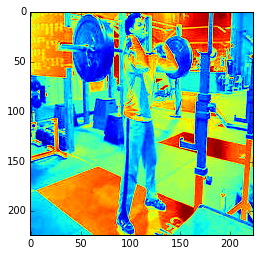

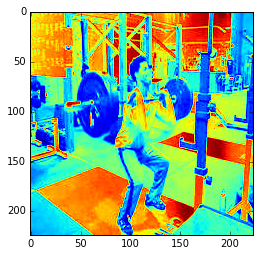

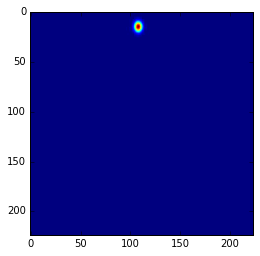

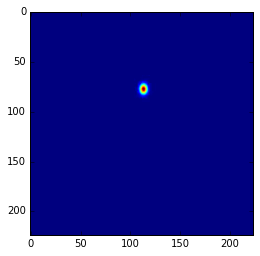

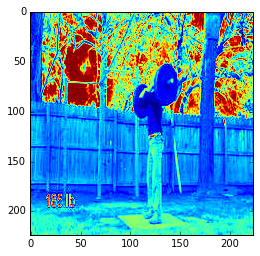

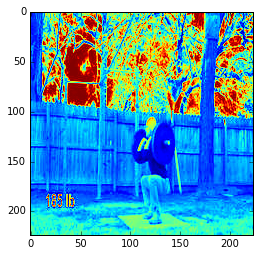

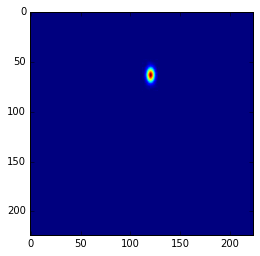

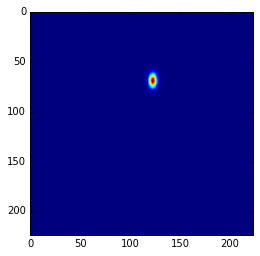

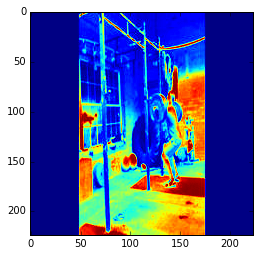

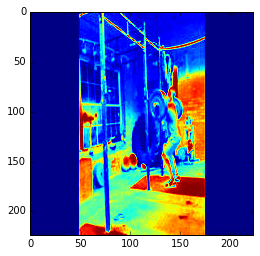

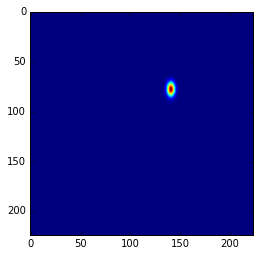

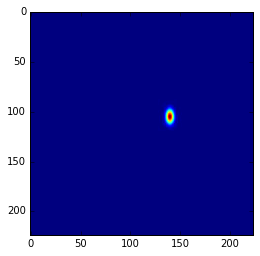

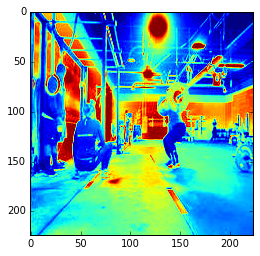

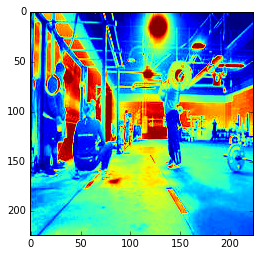

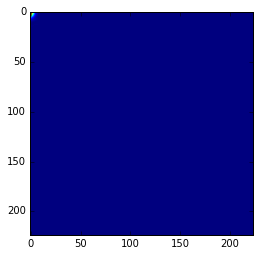

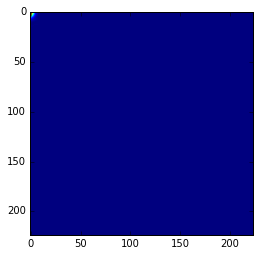

In [20]:
for i in range(4):
    plt.imshow(f1[i][:,:,0])
    plt.show()
    plt.imshow(f2[i][:,:,0])
    plt.show()
    plt.imshow(h1[i][:,:,0])
    plt.show()
    plt.imshow(h2[i][:,:,0])
    plt.show()

In [13]:
# saver = tf.train.Saver()
# saver.restore(sess, '/media/jeffzhang/WD HDD/model/multi-labels-test2')

INFO:tensorflow:Restoring parameters from /media/jeffzhang/WD HDD/model/multi-labels-adagrad/multi-labels-100


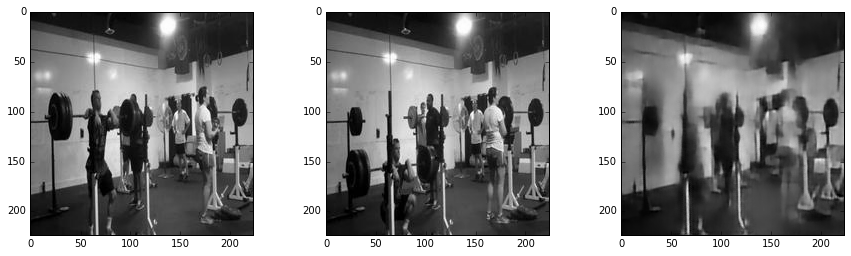

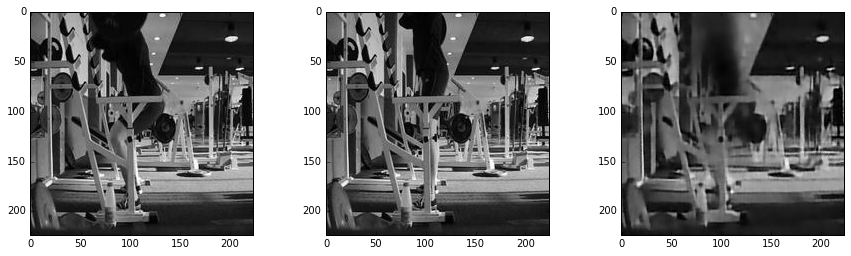

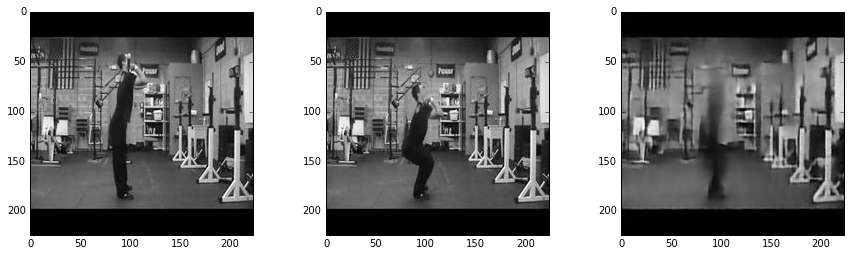

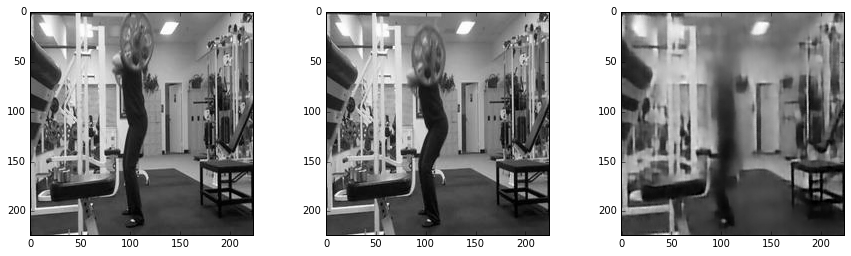

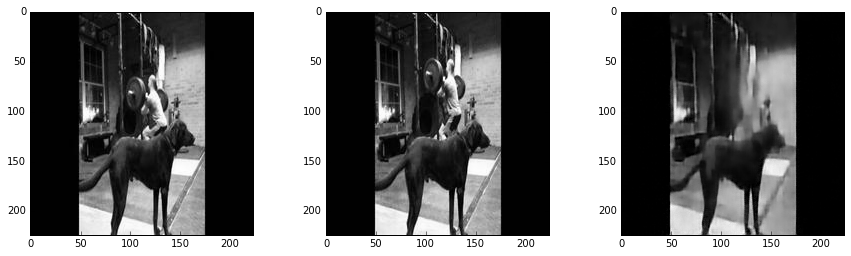

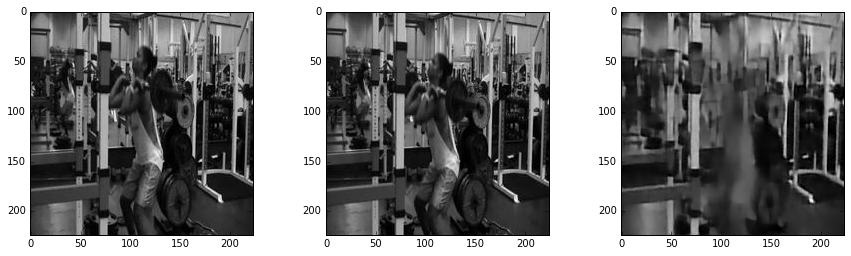

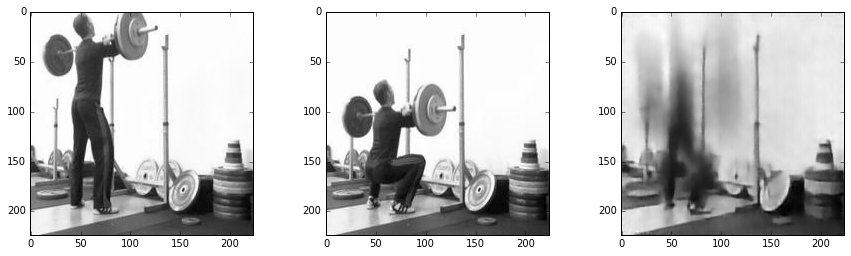

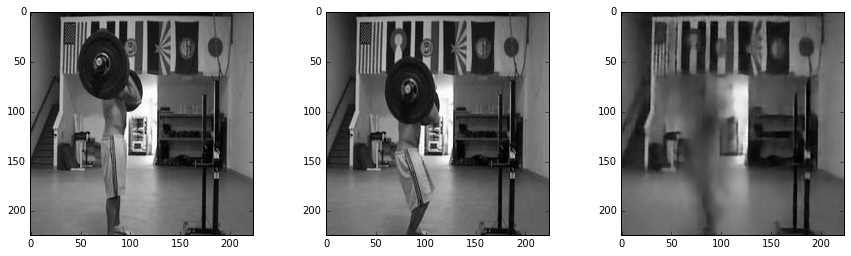

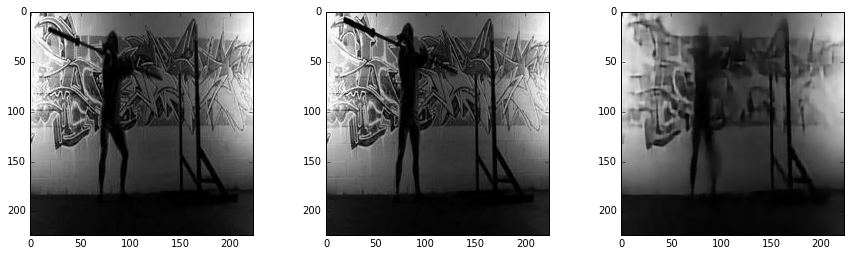

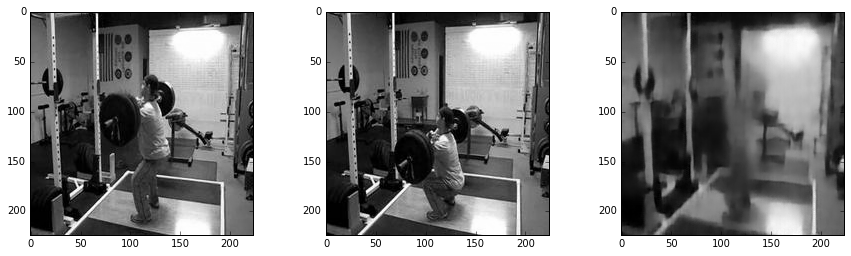

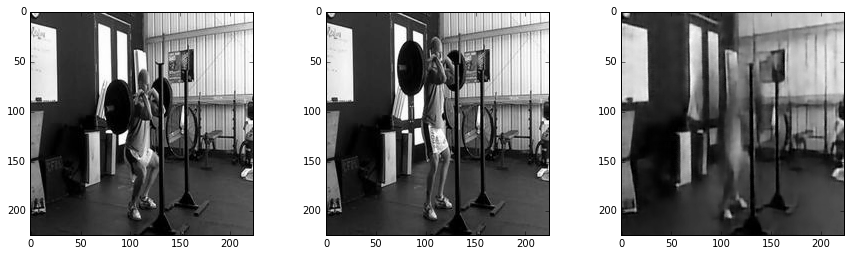

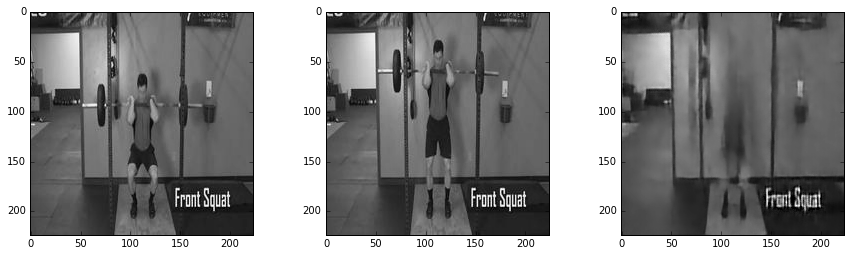

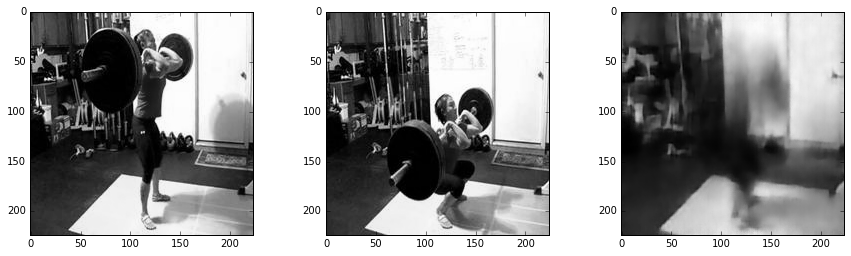

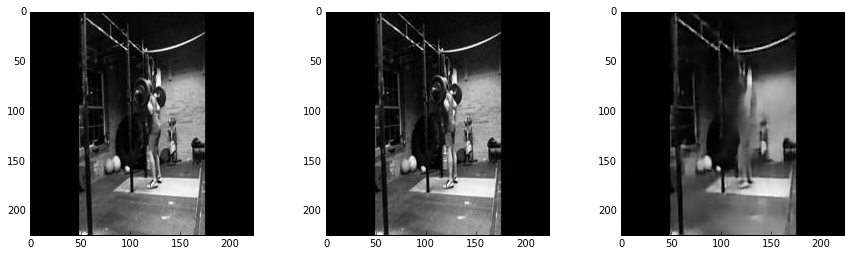

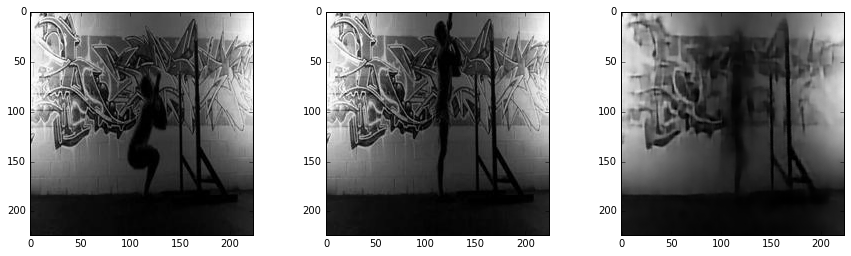

In [15]:
total_test = 5
for i in range(total_test):
    f1,f2,h1,h2 = create_minibatch(3)
    gen_img = generator.test_batch(sess,h1,h2,f1,f2)
    for i in range(3):
        plt.figure(figsize=(15,4))

        plt.subplot(131)
        plt.imshow(f1[i].reshape((224,224)), cmap = 'gray')

        plt.subplot(132)
        plt.imshow(f2[i].reshape((224,224)), cmap = 'gray')

        plt.subplot(133)
        plt.imshow(gen_img[i].reshape((224,224)), cmap = 'gray')
        plt.show()


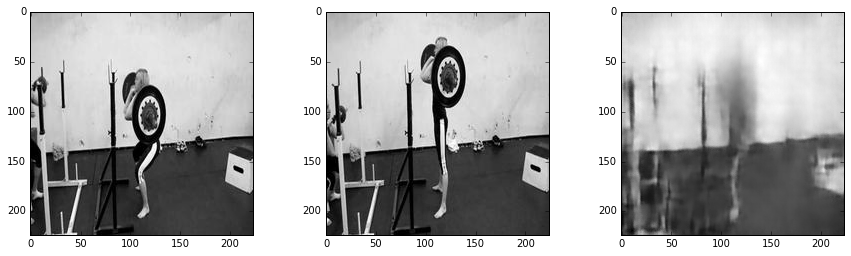

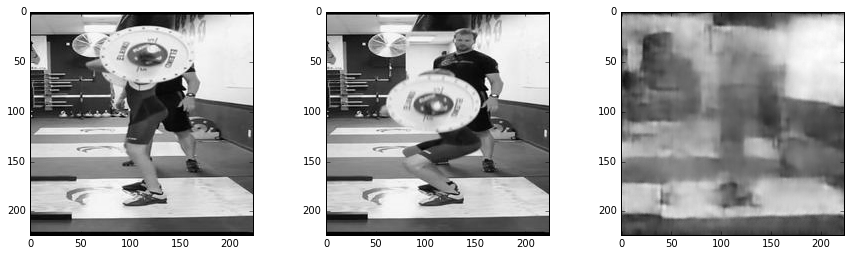

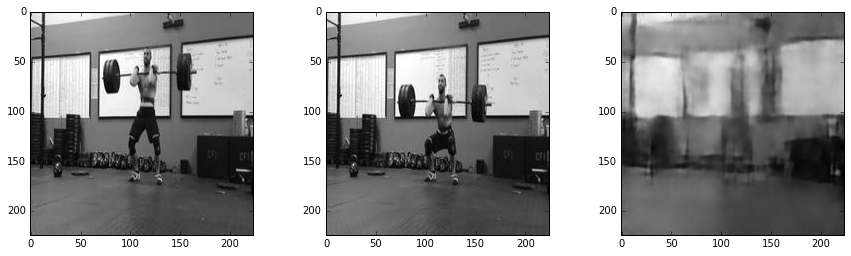

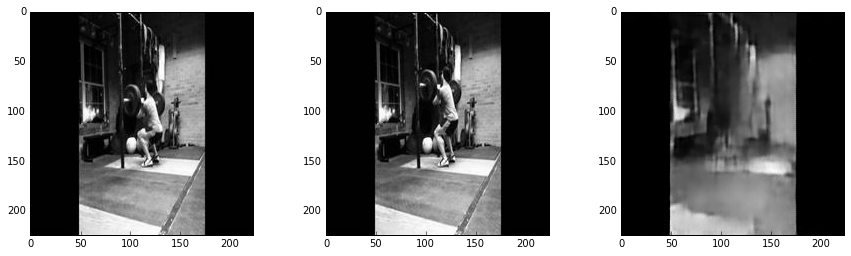

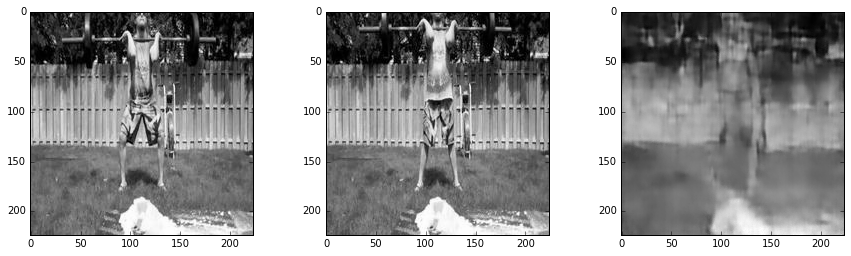

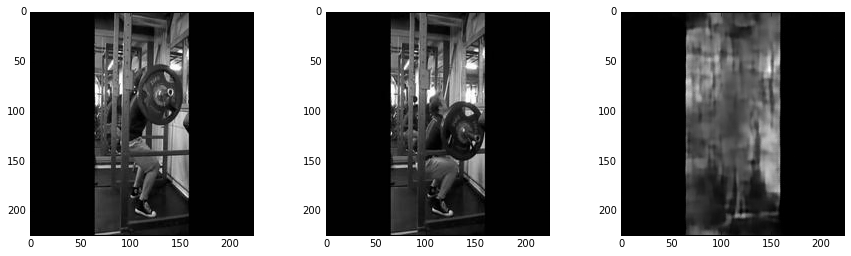

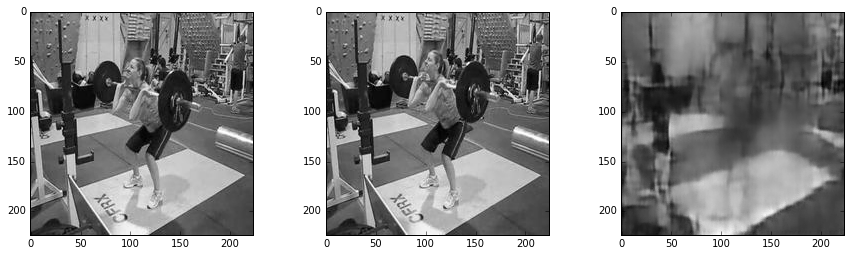

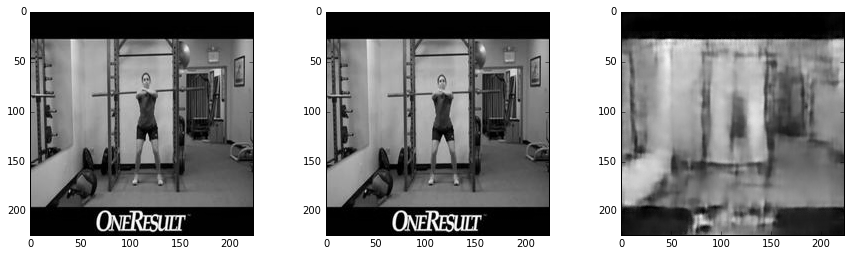

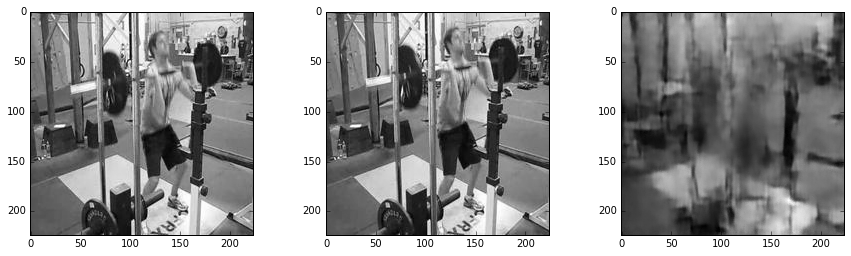

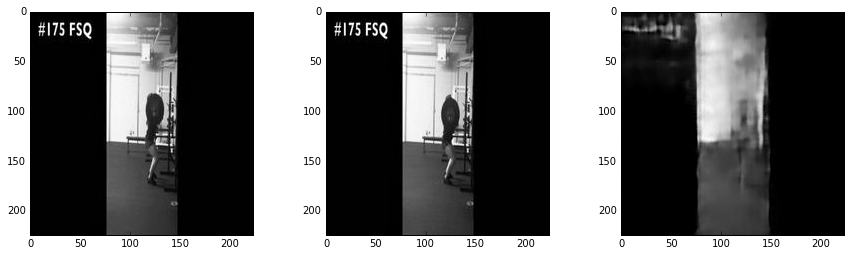

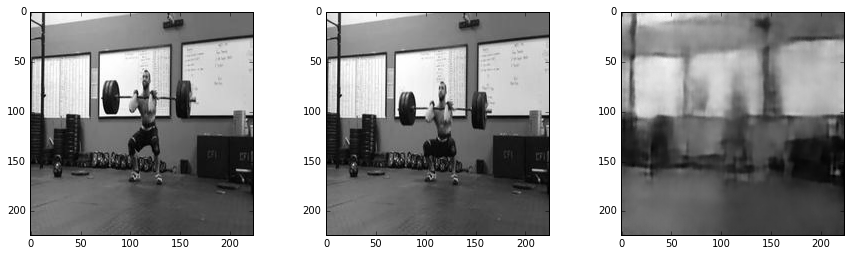

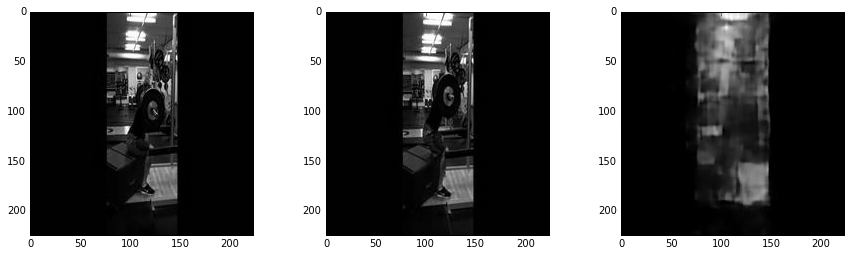

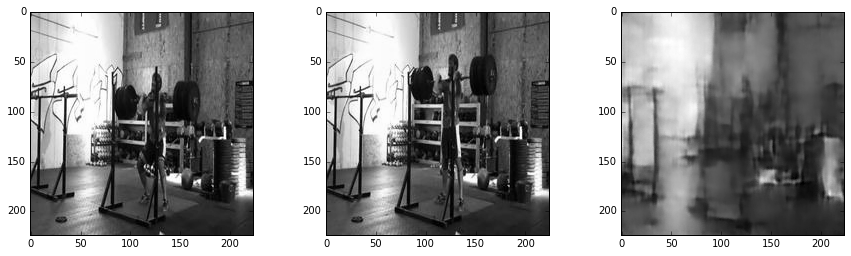

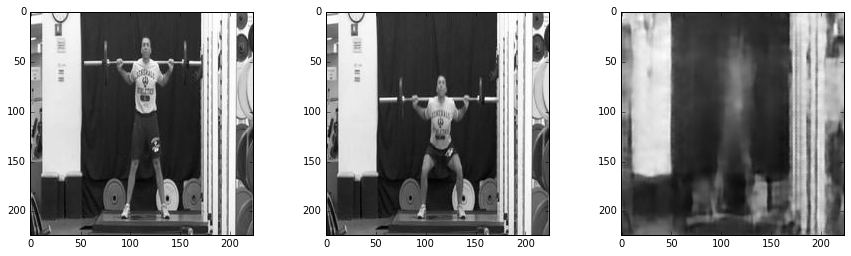

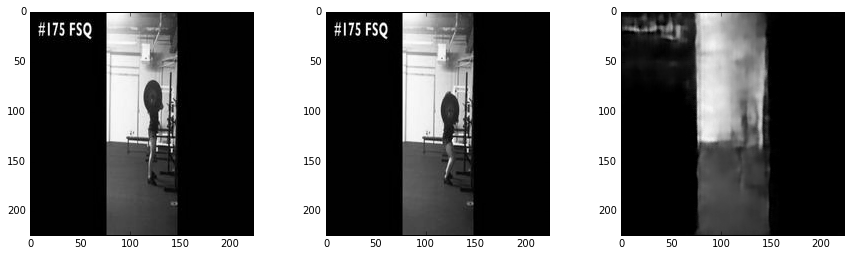

In [18]:
total_test = 5
for i in range(total_test):
    f1,f2,h1,h2 = create_minibatch_test(3)
    gen_img = generator.test_batch(sess,h1,h2,f1,f2)
    for i in range(3):
        plt.figure(figsize=(15,4))

        plt.subplot(131)
        plt.imshow(f1[i].reshape((224,224)), cmap = 'gray')

        plt.subplot(132)
        plt.imshow(f2[i].reshape((224,224)), cmap = 'gray')

        plt.subplot(133)
        plt.imshow(gen_img[i].reshape((224,224)), cmap = 'gray')
        plt.show()
